[ DNN 모델 ]

In [87]:
from torch import nn

In [88]:
# 문장 분류 모델 클래스 생성

class SentenceClassifier(nn.Module):
    
    def __init__(self, 
                 n_vocab,             # n_vocab: 단어 사전(vocabulary)의 크기 (총 단어 수)
                 hidden_dim,          # hidden_dim: RNN의 은닉 상태(hidden state)의 크기 (출력 차원)
                 embedding_dim,       # embedding_dim: 단어 임베딩(embedding) 벡터의 차원 (특징 수)
                 n_layers,            # n_layers: RNN 층의 개수 (몇 층으로 쌓을지 결정)
                 dropout=0.5,         # dropout: 드롭아웃(dropout) 비율 (과적합 방지를 위한 노드 무작위 비활성화 비율)
                 bidirectional=True,  # bidirectional: 양방향 RNN 여부 (True: 양방향, False: 단방향)
                 model_type="lstm"):
        super().__init__()
        
        
        # 임베딩
        self.embedding = nn.Embedding(num_embeddings=n_vocab,
                                      embedding_dim=embedding_dim,
                                      padding_idx=0)
        
        
        if model_type == 'rnn':
            self.model = nn.RNN(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                num_layers=n_layers,
                                bidirectional=bidirectional,
                                dropout=dropout,
                                batch_first=True)
            
            
        elif model_type == 'lstm':
            self.model = nn.LSTM(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                num_layers=n_layers,
                                bidirectional=bidirectional,
                                dropout=dropout,
                                batch_first=True)
        
        
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim,1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:,-1,:]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [89]:
# 파일 불러오기
import pandas as pd


text = 'IMDb_Reviews.csv'

corpus_df = pd.read_csv(text)

In [90]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [91]:
# 데이터의 균형성 확인
corpus_df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [92]:
# 데이터 토큰화 및 단어 사전 구축 함수
from konlpy.tag import Okt
from collections import Counter

def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    
    for tokens in corpus:
        counter.update(tokens)
        
    vocab = special_tokens
    
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
        
    return vocab

In [93]:
# 구두점 제거 
import string
import pandas as pd

for_remove = string.punctuation

# 구두점 제거 함수
def remove_punctuation(text):
    return ''.join(char for char in text if char not in string.punctuation)

# review 열에서 구두점 제거
corpus_df['punc_review'] = corpus_df['review'].apply(remove_punctuation)

# 결과 출력
print(corpus_df)

                                                  review  sentiment  \
0      My family and I normally do not watch local mo...          1   
1      Believe it or not, this was at one time the wo...          0   
2      After some internet surfing, I found the "Home...          0   
3      One of the most unheralded great works of anim...          1   
4      It was the Sixties, and anyone with long hair ...          0   
...                                                  ...        ...   
49995  the people who came up with this are SICK AND ...          0   
49996  The script is so so laughable... this in turn,...          0   
49997  "So there's this bride, you see, and she gets ...          0   
49998  Your mind will not be satisfied by this nobud...          0   
49999  The chaser's war on everything is a weekly sho...          1   

                                             punc_review  
0      My family and I normally do not watch local mo...  
1      Believe it or not this

In [94]:
# 불용어 제거
from nltk.corpus import stopwords
import nltk
import pandas as pd

# nltk stopwords 데이터 다운로드
english_stopwords = set(stopwords.words('english'))

# 불용어 제거 함수
def remove_stopwords(text): 
    text = text.lower()  # 전체 문장 소문자화
    return ' '.join(word for word in text.split() if word not in english_stopwords)

# review 열에서 불용어 제거
corpus_df['stopword_review'] = corpus_df['punc_review'].apply(remove_stopwords)

# 결과 출력
print(corpus_df)


                                                  review  sentiment  \
0      My family and I normally do not watch local mo...          1   
1      Believe it or not, this was at one time the wo...          0   
2      After some internet surfing, I found the "Home...          0   
3      One of the most unheralded great works of anim...          1   
4      It was the Sixties, and anyone with long hair ...          0   
...                                                  ...        ...   
49995  the people who came up with this are SICK AND ...          0   
49996  The script is so so laughable... this in turn,...          0   
49997  "So there's this bride, you see, and she gets ...          0   
49998  Your mind will not be satisfied by this nobud...          0   
49999  The chaser's war on everything is a weekly sho...          1   

                                             punc_review  \
0      My family and I normally do not watch local mo...   
1      Believe it or not th

In [95]:
# 정규화 
from nltk.stem import LancasterStemmer, WordNetLemmatizer   # 어간 추출과 표제어 추출 모듈 로딩

wnLemma = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(wnLemma.lemmatize(word) for word in text.split())

corpus_df['lemmatized_review'] = corpus_df['stopword_review'].apply(lemmatize_text)

# 결과 출력
print(corpus_df)

                                                  review  sentiment  \
0      My family and I normally do not watch local mo...          1   
1      Believe it or not, this was at one time the wo...          0   
2      After some internet surfing, I found the "Home...          0   
3      One of the most unheralded great works of anim...          1   
4      It was the Sixties, and anyone with long hair ...          0   
...                                                  ...        ...   
49995  the people who came up with this are SICK AND ...          0   
49996  The script is so so laughable... this in turn,...          0   
49997  "So there's this bride, you see, and she gets ...          0   
49998  Your mind will not be satisfied by this nobud...          0   
49999  The chaser's war on everything is a weekly sho...          1   

                                             punc_review  \
0      My family and I normally do not watch local mo...   
1      Believe it or not th

In [96]:
# train, test 분리
train = corpus_df.sample(frac=0.9, random_state=42)
test = corpus_df.drop(train.index)

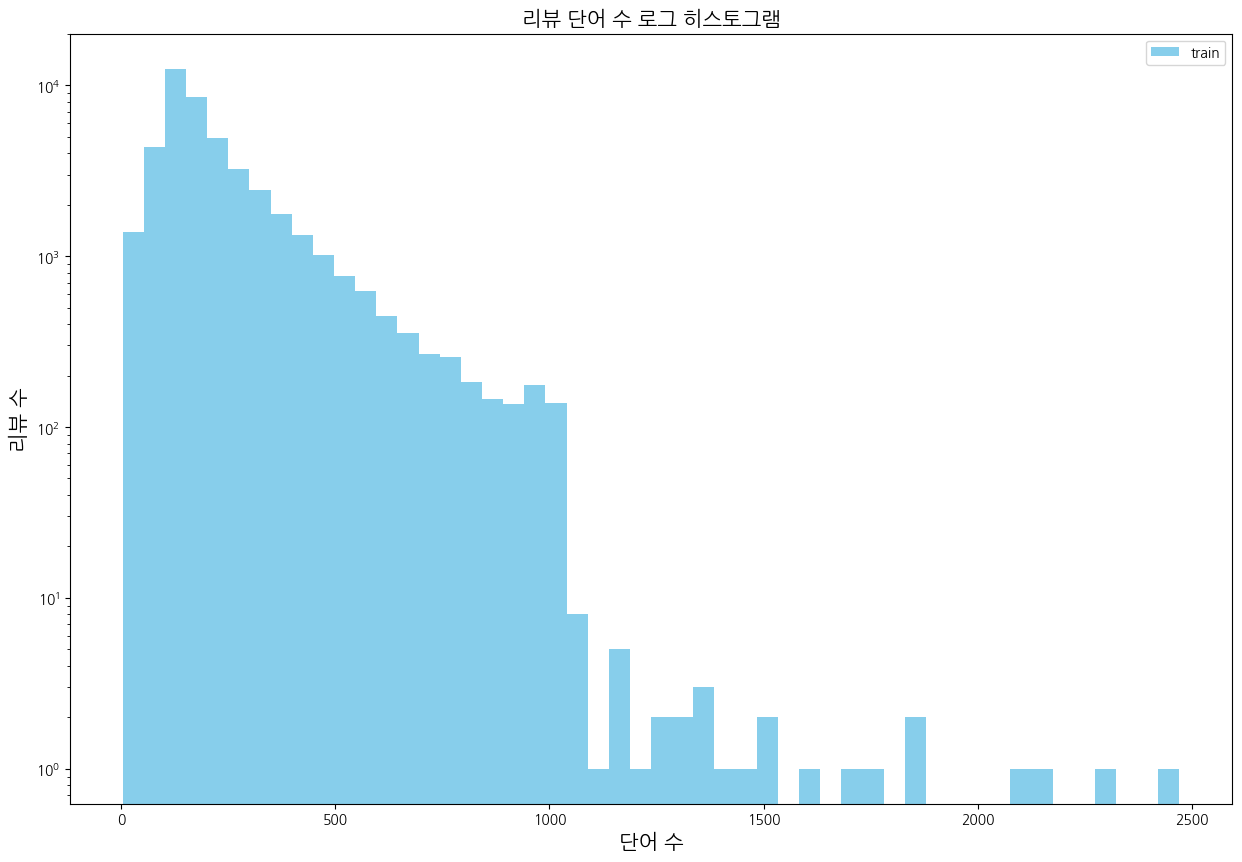

In [97]:
# 문장 길이 분포 시각화
# 로그 히스토그램 : 히스토그램의 Y축을 로그 스케일로 표현한 그래프
# 작은 값과 큰 값의 차이를 더 잘 비교할 수 있음
import matplotlib.pyplot as plt
import koreanize_matplotlib

train_word_counts = train['review'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='skyblue', label='train')
plt.title('리뷰 단어 수 로그 히스토그램', fontsize=15)
plt.yscale('log')    # Y축 로그화
plt.legend()
plt.xlabel('단어 수', fontsize=15)
plt.ylabel('리뷰 수', fontsize=15)
plt.show()

In [98]:
# 통곗값 확인
import numpy as np

print('리뷰 길이 최댓값: {}'.format(np.max(train_word_counts)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_word_counts)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 길이 중간값: {}'.format(np.median(train_word_counts)))

리뷰 길이 최댓값: 2470
리뷰 길이 최솟값: 4
리뷰 길이 평균값: 230.68
리뷰 길이 표준편차: 170.78
리뷰 길이 중간값: 173.0


In [99]:
tokenizer = Okt()
train_tokens = [tokenizer.morphs(review) for review in train.lemmatized_review]
test_tokens = [tokenizer.morphs(review) for review in test.lemmatized_review]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>","<unk>"])
token_to_id = {token:idx for idx,token in enumerate(vocab)}
id_to_token = {idx:token for idx,token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))  # 스페셜 토큰 + 5000개의 단어 사전 크기

['<pad>', '<unk>', 'br', 'movie', 'film', 'one', 'like', 'time', 'good', 'character']
5002


In [100]:
# 정수 인코딩 및 패딩
import numpy as np

def pad_sequences(sequences, max_length, pad_value):
    result = list()
    
    for sequence in sequences:
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)
        
    return np.asarray(result)

In [101]:
unk_id = token_to_id["<unk>"]

train_ids = [[token_to_id.get(token,unk_id) for token in review] for review in train_tokens]
test_ids = [[token_to_id.get(token,unk_id) for token in review] for review in test_tokens]

In [102]:
max_length = 32
pad_id = token_to_id["<pad>"]

train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[ 362   36    4    1   16  391    1    2  229 1827    1  468 4200    1
   12   90 1160    5  356  150    7  227  150   19  931    3   42  752
    1   29  305    9]
[ 617 2086  137    5   49    4   50  410   22    1   36    4  867  741
    6  127   30  505  285  432   15  580   31    1  679   50  432   13
    1    3  259   68]


In [103]:
# 데이터로더 적용 
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.sentiment.values, dtype=torch.float32)
test_labels = torch.tensor(test.sentiment.values, dtype=torch.float32)

# 데이터 셋 생성
train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [104]:
# 입력층의 크기 확인 : 32
for x, y in train_loader:
    print("입력 벡터 크기:", x.shape)  # 보통 (batch_size, input_dim)
    break

입력 벡터 크기: torch.Size([16, 32])


In [105]:
## 필요한 모듈로딩
import pandas as pd                                     ## 데이터 관련 모듈들
import numpy as np 

import torch                                            ## Tensor 및 기본 함수들 관련 모듈들
import torch.nn as nn                                   ## 인공신경망 관련 모듈들
import torch.nn.functional as F                         ## 인공신경망 관련 함수들
import torch.optim as optim                             ## 최적화 모듈
from torch.utils.data import Dataset, DataLoader        ## 학습 데이터셋 관련 모듈

from sklearn.model_selection import train_test_split    ## 학습용 데이터셋 관련 함수

import torchmetrics.functional as metrics

from torchmetrics.classification import *  # 분류 

In [106]:
class Dnn_Model(nn.Module):
    
    def __init__(self, in_in, in_out, h1_out, h2_out, out_out):
        super().__init__()
        pass
        
        self.input_layer = nn.Linear(in_in, in_out)
        self.hidden_layer1 = nn.Linear(in_out, h1_out)
        self.hidden_layer2 = nn.Linear(h1_out, h2_out)
        self.output_layer = nn.Linear(h2_out, out_out)
        
    
    # 순방향 학습 진행 메서드 : forward로 무조건 고정!!
    # forward : 필수 오버라이딩 메서드 
    # 매개변수 data : 학습용 데이터 전달
    
    # 입력층 학습 
    def forward(self,data):     
        output = self.input_layer(data)
        output = F.relu(output)
        
        output = self.hidden_layer1(output)
        output = F.relu(output)
        
        output = self.hidden_layer2(output)
        output = F.relu(output)
        
        output = self.output_layer(output)
        output = F.sigmoid(output)
    
        return output

In [107]:
EPOCHS      = 10                                    # 학습용 DS을 처음부터 끝까지 1번 학습하는 것을 에포크
BATCH_SIZE  = 128                                    # DS을 학습량 만큼 나눈 사이즈 
ITERATION   = int(train.shape[0]/BATCH_SIZE)      # 학습용 DS이 분리된 수 => 1에포크에 W, b 업데이트 횟수

# 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정 
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE : {DEVICE}, EPOCHS : {EPOCHS}, BATCH_SIZE : {BATCH_SIZE} ITERATION : {ITERATION}')

DEVICE : cpu, EPOCHS : 10, BATCH_SIZE : 128 ITERATION : 351


In [108]:
TRAINDL = DataLoader(train_dataset, batch_size=16, shuffle=True)
TESTDL  = DataLoader(test_dataset, batch_size=16, shuffle=False)

LR = 0.01  
model = Dnn_Model(32,64,32,16,1)              # 학습 모델
OPTIMIZER = optim.Adam(model.parameters(),lr=LR)   # 최적화, 즉 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.BCELoss()                       # 이진 분류 손실계산 인스턴스


In [109]:
##- 검증 함수 --------------------------------------------
##- 검증용 데이터셋으로 모델 검증
##- 학습 지속여부 결정 기준이 됨
##- -----------------------------------------------------
def evaluate():
    model.eval()

    with torch.no_grad():
        T_LOSS, T_ACC, CNT = 0, 0, 0

        for feature, target in TESTDL:
            # 입력 데이터 flatten 및 자료형 통일
            feature = feature.view(feature.size(0), -1).float()
            target = target.view(-1, 1).float()

            pre_y = model(feature)

            # 손실 및 정확도 계산
            loss = LOSS_FN(pre_y, target)
            Accuracy = BinaryAccuracy()
            acc = Accuracy(pre_y, target)

            T_LOSS += loss.item()
            T_ACC += acc.item()
            CNT += 1

        return T_LOSS / CNT, T_ACC / CNT


In [110]:
##- 학습 함수 --------------------------------------------
##- 학습용 데이터셋으로 모델 검증
##- -----------------------------------------------------
def training():
    model.train()

    E_LOSS, E_ACC = 0, 0

    for feature, target in TRAINDL:
        OPTIMIZER.zero_grad()

        # Flatten + dtype 변환
        feature = feature.view(feature.size(0), -1).float()
        target = target.view(-1, 1).float()

        pre_y = model(feature)

        # 손실 및 정확도 계산
        loss = LOSS_FN(pre_y, target)
        Accuracy = BinaryAccuracy()
        acc = Accuracy(pre_y, target)

        loss.backward()
        OPTIMIZER.step()

        E_LOSS += loss.item()
        E_ACC += acc.item()

    return E_LOSS / len(TRAINDL), E_ACC / len(TRAINDL)



In [111]:
# 학습 / 검증 동시 진행 

LOSS_HIST = {'Train': [], 'Valid': []}

for epoch in range(EPOCHS):
    trainLoss, trainAcc = training()
    validLoss, validAcc = evaluate()
    
    LOSS_HIST['Train'].append((trainLoss, trainAcc))
    LOSS_HIST['Valid'].append((validLoss, validAcc))
    
    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]------------------------')
    print(f'TRAIN LOSS  {trainLoss:.5f}   |  ACC: {trainAcc:.4f}')
    print(f'VALID LOSS  {validLoss:.5f}   |  ACC: {validAcc:.4f}')


EPOCH[1/10]------------------------
TRAIN LOSS  50.00404   |  ACC: 0.4996
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[2/10]------------------------
TRAIN LOSS  50.00444   |  ACC: 0.5000
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[3/10]------------------------
TRAIN LOSS  50.00889   |  ACC: 0.4999
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[4/10]------------------------
TRAIN LOSS  50.00222   |  ACC: 0.5000
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[5/10]------------------------
TRAIN LOSS  50.00444   |  ACC: 0.5000
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[6/10]------------------------
TRAIN LOSS  50.00000   |  ACC: 0.5000
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[7/10]------------------------
TRAIN LOSS  50.00667   |  ACC: 0.4999
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[8/10]------------------------
TRAIN LOSS  50.00667   |  ACC: 0.4999
VALID LOSS  50.01997   |  ACC: 0.4998

EPOCH[9/10]------------------------
TRAIN LOSS  50.00444   |  ACC: 0.5000
VALID LOSS  50.01997 